In [1]:
import pickle
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import zscore
from matplotlib.patches import Rectangle, Patch



sys.path.insert(0, '../4_preffect')
from _config import configs
from preffect_factory import factory
import anndata as ad 
from _inference import( Inference )

In [ ]:
# Pick file you're going to evaluate

# dataset
dataset_run = "dataset_omega_batch_1/L_Million_rprime128/"

image_save = "/path/to/3_omega_batch_dataset_run_analysis/" + dataset_run
# Create directory
if not os.path.exists(image_save):
    os.makedirs(image_save)

def list_subfolders(directory):
    subfolders = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
    return subfolders

# created a sorting algorithm to ensure "epoch_100" is sorted after "epoch_50"
def sort_key(s):
    s = re.sub(r'\s+', '', s)
    # Extract the number from the folder name (assuming every folder name has the format 'test_<number>')
    match = re.search(r'\d+$', s)
    if match:
        return int(match.group())
    return s

#folder_search = f'/path/to/{dataset_run}/initial_testing'
folder_search = f'/path/to/{dataset_run}'


all_subfolders = sorted(list_subfolders(folder_search), reverse=False)

#all_subfolders.sort(key=sort_key)

#all_subfolders = all_subfolders[3:4]
all_subfolders = all_subfolders[0:10]

print("All sub-folders:", all_subfolders)

All sub-folders: ['Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01', 'Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01_LibLearn', 'Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01_LibLearn_2', 'Simple_E2000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01_LibLearn']


In [3]:
# Re-instate the model (models?)
configs['task'] = 'reinstate'

pr_reinstate = {}
pr_count = 0

for dir_name in all_subfolders:

    dir_name = re.sub(r'\s+', '', dir_name)
    full_path = folder_search + "/" + dir_name
    configs['output_path'] = full_path
    configs['cuda_device_num'] = 4
    pr_reinstate[pr_count] = factory(task='reinstate', configs=configs, trigger_setup=True)
    
    #configs['input_inference_anndata_path'] = configs['input_anndata_path'] + 'test/' 
    #configs['task'] = 'impute_experiment'
    #infy, error_masked, error_unmasked, df_subtype  = factory(task='impute_experiment', configs=configs, 
    #                                                preffect_obj=pr_reinstate, inference_key = 'endogenous',
    #                                                error_type='mse')

    configs['always_save'] = False


    pr_count += 1

    # 1 model at a time for now
    # break


In [4]:
loop_count = 0
for dir_name in all_subfolders:
    print(dir_name)
    print("Latent Space")
#    factory(task='cluster_latent', preffect_obj=pr_reinstate[loop_count], inference_key='endogenous', trigger_setup=False, configs=configs)
    loop_count += 1

    break

Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01
Latent Space


Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01
Omega after endogenous inference


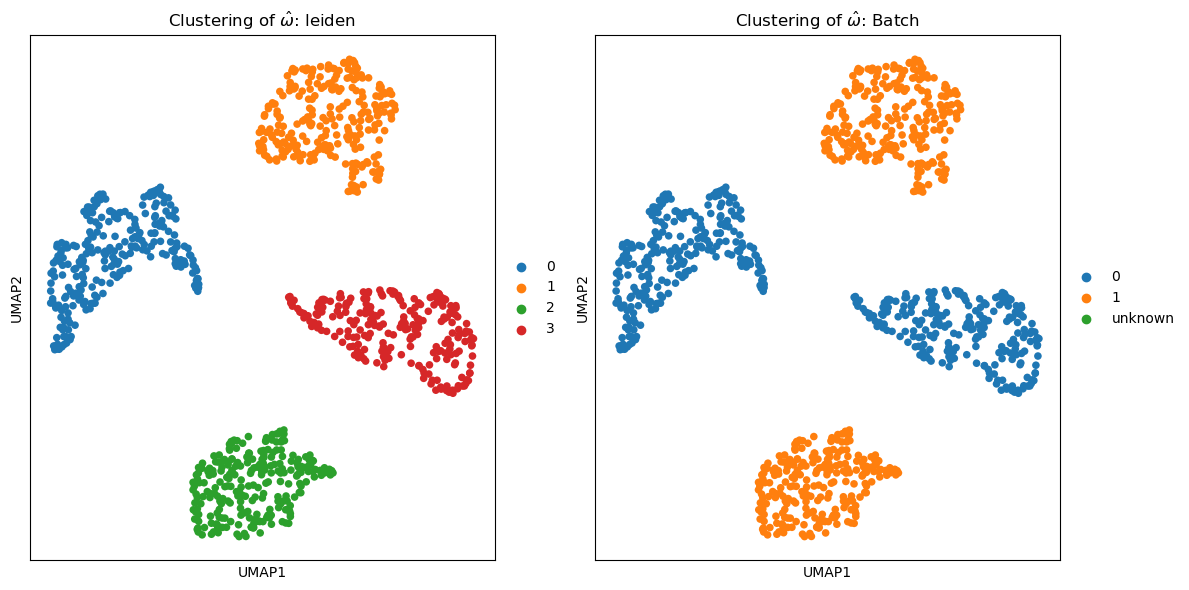

In [5]:
# Clustering of Omega after the run


loop_count = 0
for dir_name in all_subfolders:
    print(dir_name)
    print("Omega after endogenous inference")
    factory(task='cluster_counts', preffect_obj=pr_reinstate[loop_count], inference_key='endogenous', trigger_setup=False, configs=configs)
    loop_count += 1



Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01


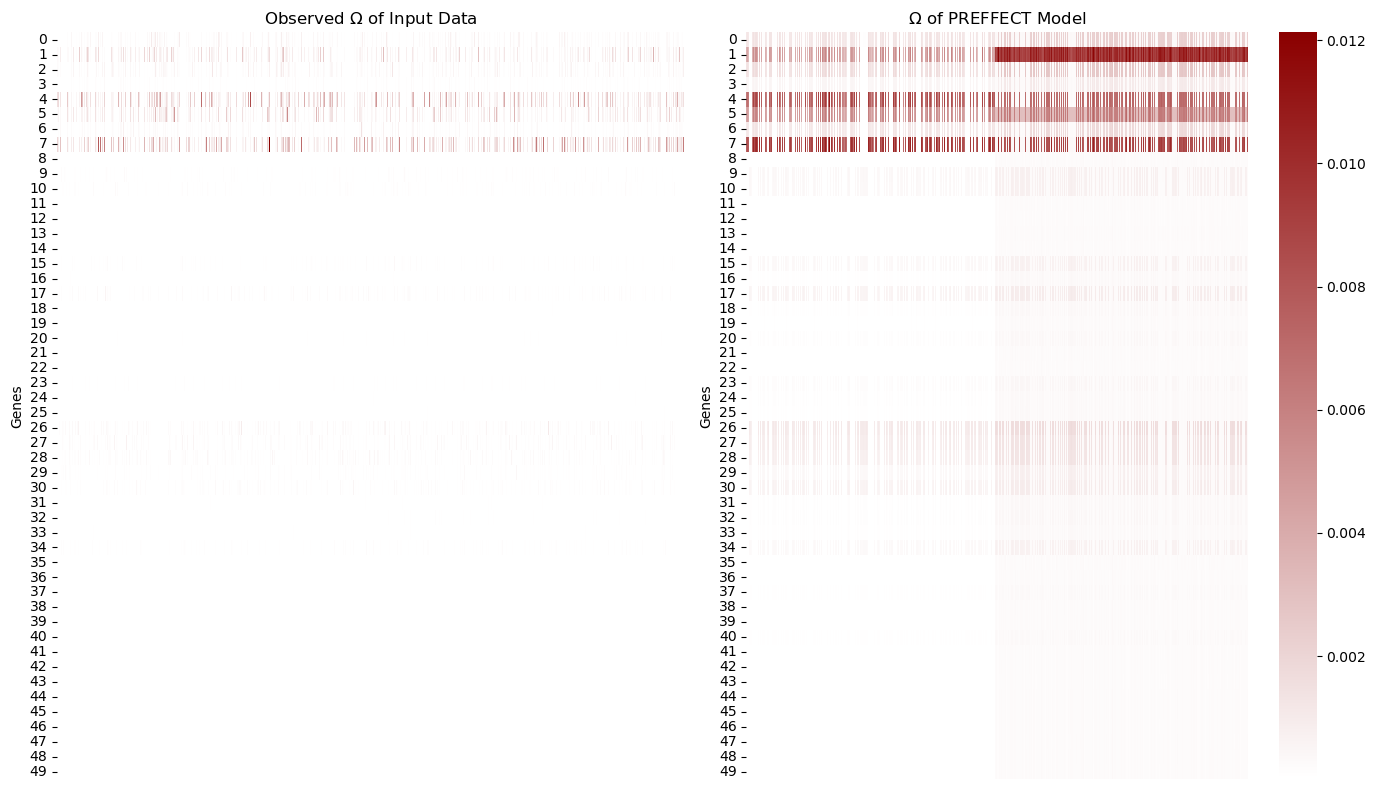

In [6]:
# I'd like heatmaps of Omega


category_colors = {
    '0': 'blue',
    '1': 'orange',
}
white_red_cmap = LinearSegmentedColormap.from_list('white_red', ['white', 'darkred'])
# Map the vector categories to colors

#category_order = category_omegas.pop(category_omegas.columns[-1])

#category_bar = category_order.map(category_colors)

loop_count = 0
for dir_name in all_subfolders:
    print(dir_name)
    category_omegas_list, category_true_omegas_list = [], []

    model = loop_count
    inf_reinstate = pr_reinstate[model].inference_dict['endogenous']
    adata = inf_reinstate.return_counts_as_anndata()
    
    # continuing on, lets pull Mu/Theta for this gene
    hat_mu = adata[0].X
    hat_theta = adata[0].layers["X_hat_theta"]
    true_counts = adata[0].layers["original_counts"]
        
    # lets convert true counts to omega
    library_size = np.sum(true_counts, axis=1)

    # Calculate omega (proportion of library size for each gene)
    true_omega = true_counts / library_size[:, np.newaxis]
            
    omega = adata[0].layers["px_omega"]

    batches = adata[0].obs['batch'].astype('category')

    gene_order = inf_reinstate.ds.gene_names

    categories = batches.cat.categories
    category_omegas = {category: omega[batches == category] for category in categories}
    category_true_omega = {category: true_omega[batches == category] for category in categories}

    combined_omega = np.transpose(np.vstack((category_omegas[0], category_omegas[1])))

    combined_true_omega = np.transpose(np.vstack((category_true_omega[0], category_true_omega[1])))

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))  # Adjust figsize as needed

    # Plot the first heatmap
    ax1 = sns.heatmap(
        combined_true_omega[:50],
        cmap=white_red_cmap,
        cbar=False,
        xticklabels=True,
        yticklabels=True,
        ax=axes[0]
    )

    # Set title and labels for the first heatmap
    ax1.set_title(r'Observed $\Omega$ of Input Data')
    ax1.set_ylabel('Genes')
    ax1.set_xticks([])

    # Plot the second heatmap
    ax2 = sns.heatmap(
        combined_omega[:50],  
        cmap=white_red_cmap,
        cbar=True,
        xticklabels=True,
        yticklabels=True,
        ax=axes[1]
    )

    # Set title and labels for the second heatmap
    plt.title(r'$\Omega$ of PREFFECT Model')# Replace with an appropriate title
    ax2.set_ylabel('Genes')
    ax2.set_xticks([])

    plt.tight_layout()
    plt.show()





    loop_count += 1

In [ ]:
# Lets see what happens when we set everyone to batch 1
# my thought is there would be no indication that batch is sporatic
pr_count = 0


configs_inf = pr_reinstate[pr_count].configs.copy()
configs_inf['task'] = 'inference'

configs_inf['adjust_vars'] = True

print("Inferring if all Batch 0...")

configs_inf['adjust_to_batch_level'] = 0

infy = factory(task='inference', configs=configs_inf, 
                preffect_obj=pr_reinstate[pr_count], inference_key = 'test')

#print("Inferring if all Batch 1...")
#configs_inf['adjust_to_batch_level'] = 1
#infy = factory(task='inference', configs=configs_inf, 
#                preffect_obj=pr_reinstate[pr_count], inference_key = 'test')

Inference Type:  endogenous


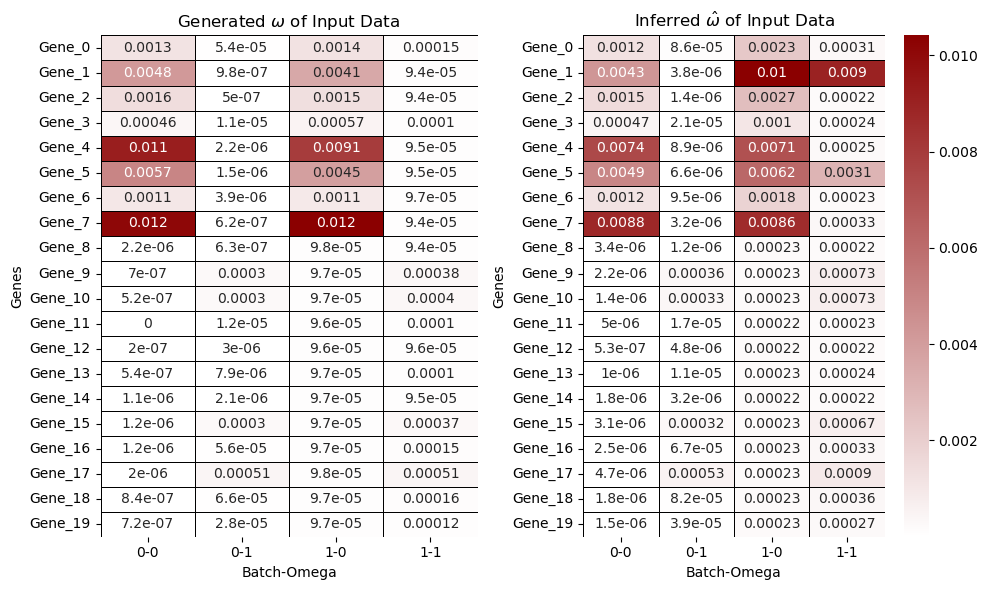

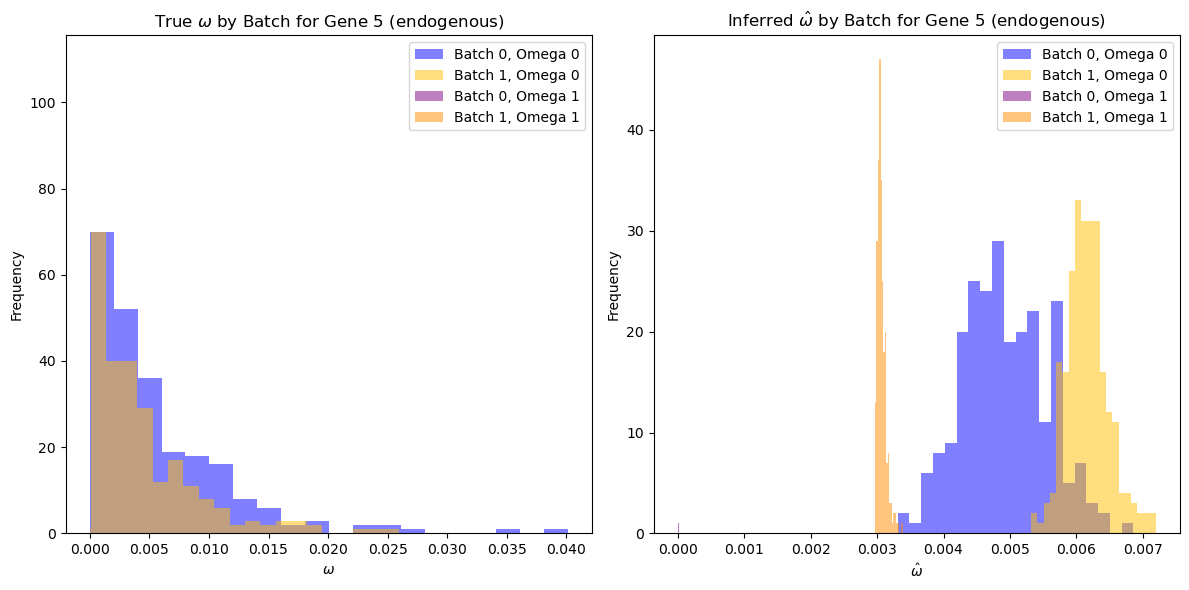

Inference Type:  inference_0


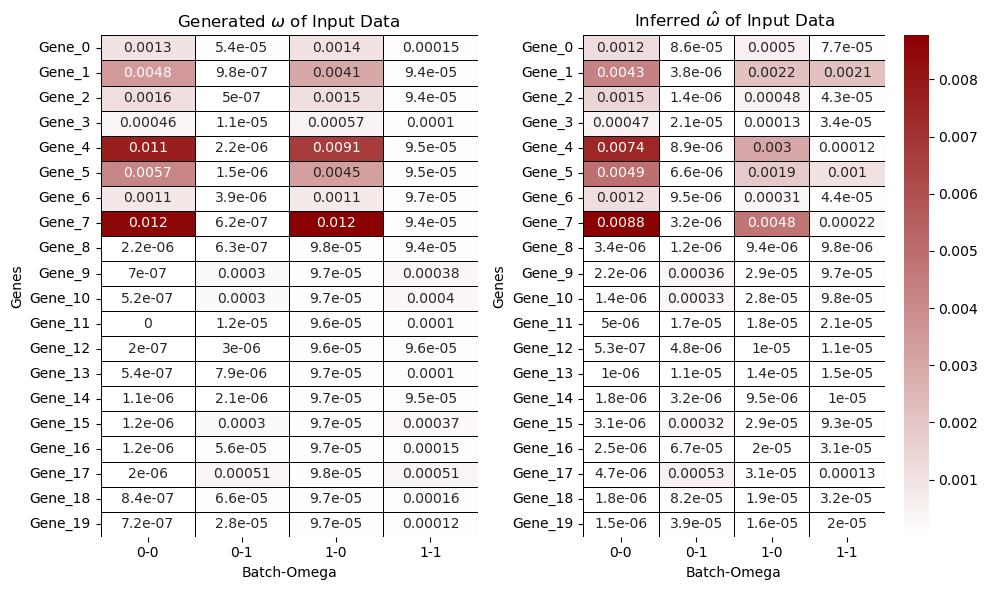

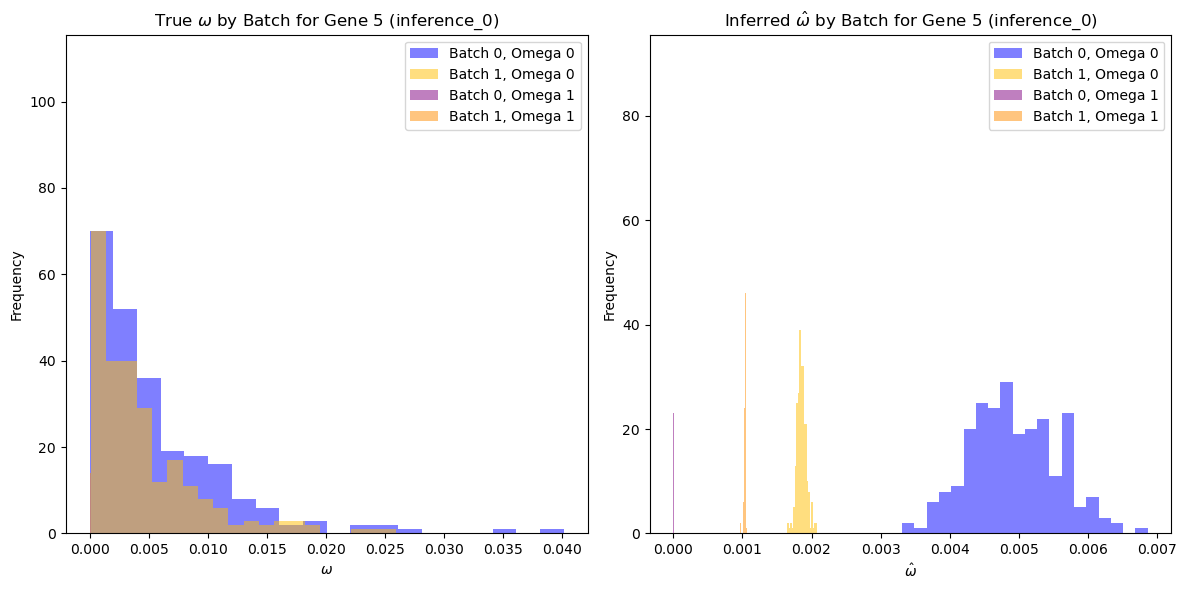

In [8]:
counter = 0

for inf_type in infy.inference_dict:
        print("Inference Type: ", inf_type)


        white_red_cmap = LinearSegmentedColormap.from_list('white_red', ['white', 'darkred'])

        category_omegas_list, category_true_omegas_list = [], []

        inf_reinstate = infy.inference_dict[inf_type]
        adata = inf_reinstate.return_counts_as_anndata()
                
        # continuing on, lets pull Mu/Theta for this gene
        hat_mu = adata[0].X
        hat_theta = adata[0].layers["X_hat_theta"]
        true_counts = adata[0].layers["original_counts"]
                
        # lets convert true counts to omega
        library_size = np.sum(true_counts, axis=1)

        # Calculate omega (proportion of library size for each gene)
        true_omega = true_counts / library_size[:, np.newaxis]
                        
        omega = adata[0].layers["px_omega"]

        batches = adata[0].obs['batch']
        omega_type = adata[0].obs['omega_type']

        gene_order = inf_reinstate.ds.gene_names

        batches = adata[0].obs['batch'].astype('category')
        categories = batches.cat.categories

        df = pd.DataFrame(omega, columns=[f'Gene_{i}' for i in range(omega.shape[1])])
        df['Batch'] = batches.to_numpy()
        df['Omega'] = omega_type.to_numpy()
        category_means_omega = df.groupby(['Batch', 'Omega']).mean().T

                
        df = pd.DataFrame(true_omega, columns=[f'Gene_{i}' for i in range(true_omega.shape[1])])
        df['Batch'] = batches.to_numpy()
        df['Omega'] = omega_type.to_numpy()
        category_means_true_omega = df.groupby(['Batch', 'Omega']).mean().T


        fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize as needed

        # Plot the first heatmap - true omega
        ax1 = sns.heatmap(
                category_means_true_omega[:20],
                cmap=white_red_cmap,
                cbar=False,
                xticklabels=True,
                yticklabels=True,
                ax=axes[0],
                annot=True,
                linewidths=0.5,  # Add thin grid lines
                linecolor='black'  # Set grid line color to black
        )

        # Set title and labels for the first heatmap
        ax1.set_title(r'Generated $\omega$ of Input Data')
        ax1.set_ylabel('Genes')


        # Plot the second heatmap - inferered omega
        ax2 = sns.heatmap(
                category_means_omega[:20],  
                cmap=white_red_cmap,
                cbar=True,
                xticklabels=True, 
                yticklabels=True,
                ax=axes[1],
                annot=True,
                linewidths=0.5,  # Add thin grid lines
                linecolor='black'  # Set grid line color to black
        )

        # Set title and labels for the second heatmap
        # plt.title(rf'$\omega$ of Inference Type: {inf_type}')# Replace with an appropriate title
        ax2.set_ylabel('Genes')

        ax2.set_title(r'Inferred $\hat{\omega}$ of Input Data')
        plt.tight_layout()
        plt.show()

        # And now lets draw a histogram of the omega values for a particular gene
        # Put true omega and omega hat side-by-side
        gene_to_focus = 5
        
        true_omega_of_interest = true_omega[:, gene_to_focus]
        omega_of_interest = adata[0].layers["px_omega"][:, gene_to_focus]

        # Batch assignments
        batch_assignment = adata[0].obs['batch']
        omega_assignment = adata[0].obs['omega_type']
        unique_omega = len(np.unique(omega_assignment))

        # Data groups for the first gene
        true_group_0 = true_omega_of_interest[(batch_assignment == 0) & (omega_assignment == 0)]
        true_group_1 = true_omega_of_interest[(batch_assignment == 1) & (omega_assignment == 0)]
        true_group_2 = true_omega_of_interest[(batch_assignment == 0) & (omega_assignment == 1)]
        true_group_3 = true_omega_of_interest[(batch_assignment == 1) & (omega_assignment == 1)]

        # Data groups for the second gene
        hat_group_0 = omega_of_interest[(batch_assignment == 0) & (omega_assignment == 0)]
        hat_group_1 = omega_of_interest[(batch_assignment == 1) & (omega_assignment == 0)]
        hat_group_2 = omega_of_interest[(batch_assignment == 0) & (omega_assignment == 1)]
        hat_group_3 = omega_of_interest[(batch_assignment == 1) & (omega_assignment == 1)]


        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot histograms for the first gene
        axes[0].hist(true_group_0, bins=20, alpha=0.5, label='Batch 0, Omega 0', color='blue')
        axes[0].hist(true_group_1, bins=20, alpha=0.5, label='Batch 1, Omega 0', color='#FFBF00')
        if (unique_omega > 1):
                axes[0].hist(true_group_2, bins=20, alpha=0.5, label='Batch 0, Omega 1', color='purple')
                axes[0].hist(true_group_3, bins=20, alpha=0.5, label='Batch 1, Omega 1', color='#FF8C00')
        axes[0].set_xlabel(r'$\omega$')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title(f'True $\omega$ by Batch for Gene {gene_to_focus} ({inf_type})')
        axes[0].legend()

        # Plot histograms for the second gene
        axes[1].hist(hat_group_0, bins=20, alpha=0.5, label='Batch 0, Omega 0', color='blue')
        axes[1].hist(hat_group_1, bins=20, alpha=0.5, label='Batch 1, Omega 0', color='#FFBF00')
        if (unique_omega > 1):
                axes[1].hist(hat_group_2, bins=20, alpha=0.5, label='Batch 0, Omega 1', color='purple')
                axes[1].hist(hat_group_3, bins=20, alpha=0.5, label='Batch 1, Omega 1', color='#FF8C00')
        axes[1].set_xlabel(r'$\hat{\omega}$')
        axes[1].set_ylabel('Frequency')
        # axes[1].set_xlim(0, 0.0005)
        axes[1].set_title(f'Inferred $\hat{{\omega}}$ by Batch for Gene {gene_to_focus} ({inf_type})')
        axes[1].legend()

        # Adjust layout and display the plots
        plt.tight_layout()
        plt.show()

        #print(np.mean(true_group_3), np.min(true_group_3), np.max(true_group_3))
        #print(np.mean(hat_group_3), np.min(hat_group_3), np.max(hat_group_3))
        

        # control how many plots are drawn
        counter += 1
        if (counter == 4):
                break


In [9]:
print(adata[0].var.iloc[357])
print()
contingency_table = pd.crosstab(adata[0].obs['batch'], adata[0].obs['omega_type'])

print(contingency_table)

gene             gene_357
omega_0               0.0
mu_0             1.240005
omega_1          0.000002
mu_1             1.512456
theta                   1
batch_applied           1
Name: gene_357, dtype: object

omega_type    0    1
batch               
0           237  259
1           251  253


Ok, so now how do I proceed?
- Omega vs Omega MRE split by parameter in obs (called 'omega_type')



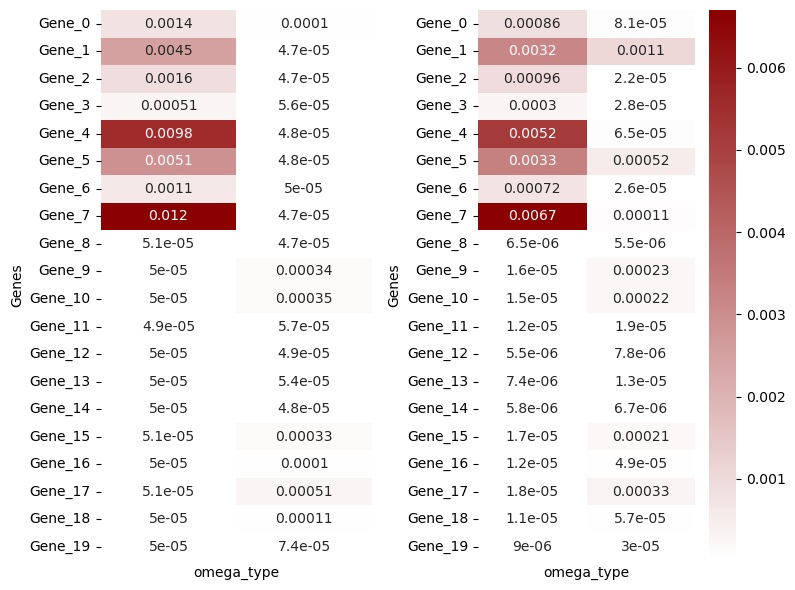

              gene   omega_0          mu_0       omega_1         mu_1  theta  \
gene_0      gene_0  0.001338   1338.404560  5.010196e-05    50.875225      1   
gene_1      gene_1  0.004392   4390.089270  1.431732e-06     0.927819      1   
gene_2      gene_2  0.001661   1660.843332  9.395741e-07     0.444841      1   
gene_3      gene_3  0.000491    491.956101  1.128567e-05    10.474642      1   
gene_4      gene_4  0.010174  10175.565230  2.520996e-06     2.060153      1   
...            ...       ...           ...           ...          ...    ...   
gene_895  gene_895  0.000422    421.013432  4.509016e-05    45.717430      1   
gene_896  gene_896  0.000631    631.638726  4.470960e-04   446.115308      1   
gene_897  gene_897  0.000335    334.590830  7.425942e-04   741.363250      1   
gene_898  gene_898  0.000912    914.550887  4.794265e-03  4795.317739      1   
gene_899  gene_899  0.001011   1012.558956  4.072760e-03  4072.131644      1   

         batch_applied  
gene_0        

In [10]:
inf_type = "inference_0"

white_red_cmap = LinearSegmentedColormap.from_list('white_red', ['white', 'darkred'])

category_omegas_list, category_true_omegas_list = [], []

inf_reinstate = infy.inference_dict[inf_type]
adata = inf_reinstate.return_counts_as_anndata()
                
# continuing on, lets pull Mu/Theta for this gene
hat_mu = adata[0].X
hat_theta = adata[0].layers["X_hat_theta"]
true_counts = adata[0].layers["original_counts"]
                
# lets convert true counts to omega
library_size = np.sum(true_counts, axis=1)

# Calculate omega (proportion of library size for each gene)
true_omega = true_counts / library_size[:, np.newaxis]
                        
omega = adata[0].layers["px_omega"]
gene_order = inf_reinstate.ds.gene_names

batches = adata[0].obs['omega_type'].astype('category')
categories = batches.cat.categories

df = pd.DataFrame(omega, columns=[f'Gene_{i}' for i in range(omega.shape[1])])
df['omega_type'] = batches.to_numpy()
category_means_omega = df.groupby('omega_type').mean().T

                
df = pd.DataFrame(true_omega, columns=[f'Gene_{i}' for i in range(true_omega.shape[1])])
df['omega_type'] = batches.to_numpy()
category_means_true_omega = df.groupby('omega_type').mean().T


fig, axes = plt.subplots(1, 2, figsize=(8, 6))  # Adjust figsize as needed

# Plot the first heatmap - true omega
ax1 = sns.heatmap(
                category_means_true_omega[:20],
                cmap=white_red_cmap,
                cbar=False,
                xticklabels=True,
                yticklabels=True,
                ax=axes[0],
                annot=True
)

# Set title and labels for the first heatmap
# ax1.set_title(r'Observed $\omega$ of Input Data')
ax1.set_ylabel('Genes')
ax1.set_xticks([])

# Plot the second heatmap - inferered omega
ax2 = sns.heatmap(
                category_means_omega[:20],  
                cmap=white_red_cmap,
                cbar=True,
                xticklabels=True, 
                yticklabels=True,
                ax=axes[1],
                annot=True
)

# Set title and labels for the second heatmap
# plt.title(rf'$\omega$ of Inference Type: {inf_type}')# Replace with an appropriate title
ax2.set_ylabel('Genes')
ax2.set_xticks([])

plt.tight_layout()
plt.show()



print(adata[0].var)

What I need to evaluate this dataset is something that splits samples by both batch and omega type, and then finds the estimated omega
And compares them through MRE I guess?

In [11]:
# functions to compute error

# MRE 
def calculate_mre(predicted_values, true_value):
    return np.mean(np.abs((predicted_values - true_value) / true_value))

# MSLE
def calculate_msle(predicted_values, true_values):
    eps = 1e-10
    return np.mean((np.log(predicted_values + eps) - np.log(true_values + eps)) ** 2)

# sMAPE
def calculate_smape(predicted_values, true_values):
    eps = 1e-8
    numerator = np.abs(predicted_values - true_values)
    denominator = (np.abs(true_values) + np.abs(predicted_values)) / 2
    # Avoid division by zero
    smape = np.mean(numerator / (denominator + eps)) * 100
    return smape


def calculate_mae(predicted_values, true_values):
    return np.mean(np.abs(predicted_values - true_values))

Inference Type:  endogenous
batch 0 omega 0
omega 0.0004542251352329634 0.0004542251352329634
Generated 227 0.00047796091429331227
Inferred 227 0.0004592417194832211
gene               gene_209
omega_0            0.000454
mu_0             454.087907
omega_1            0.000002
mu_1               2.721982
theta                     1
batch_applied             1
Name: gene_209, dtype: object
batch 0 omega 1
omega 1.8144322930415233e-06 0.0004542251352329634
Generated 227 2.693156251623094e-06
Inferred 227 6.89621486916934e-06
gene               gene_209
omega_0            0.000454
mu_0             454.087907
omega_1            0.000002
mu_1               2.721982
theta                     1
batch_applied             1
Name: gene_209, dtype: object
batch 1 omega 0
omega 0.0004542251352329634 0.0004542251352329634
Generated 227 0.0005837065232633942
Inferred 227 0.0010147221848847293
gene               gene_209
omega_0            0.000454
mu_0             454.087907
omega_1            0.000

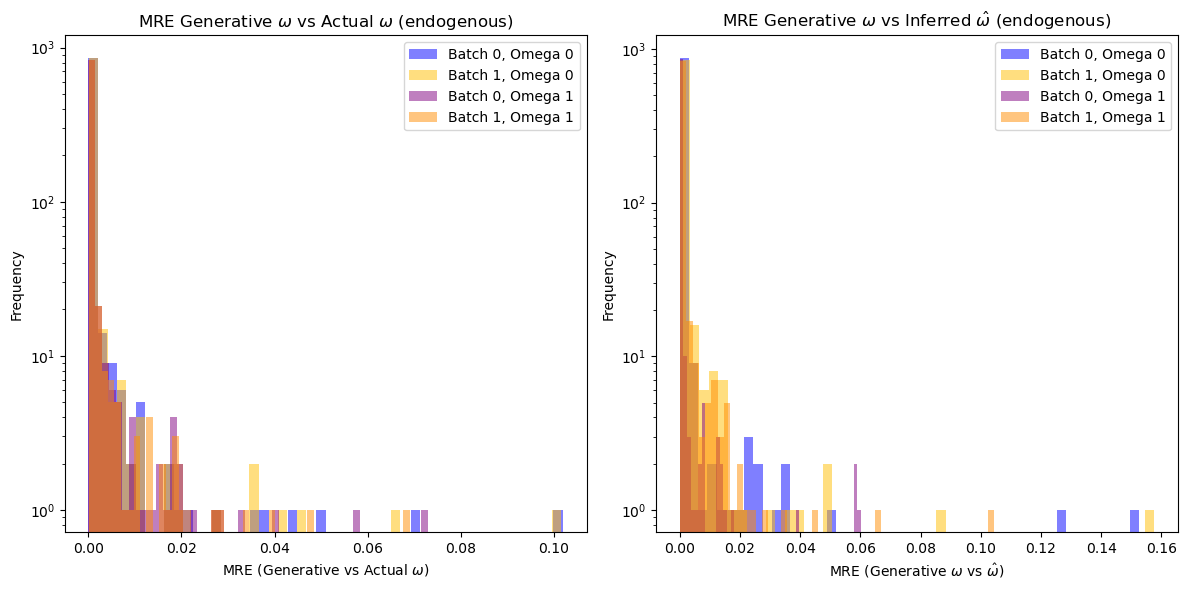

Worst True Omega [0,0]
gene                  gene_519
omega_0               0.170547
mu_0             170546.501775
omega_1                    0.0
mu_1                  0.995199
theta                        1
batch_applied                1
Name: gene_519, dtype: object
0.10193402507535357 0.17054681911870018
0.15013789314961581 0.12132128685885642

Worst True Omega [0,1]
gene                  gene_885
omega_0                0.10598
mu_0             105980.298074
omega_1               0.117874
mu_1             117874.857382
theta                        1
batch_applied                1
Name: gene_885, dtype: object
0.07301452898191121 0.11787440722463732
0.10916621402051409 0.08532597999749521

Worst Inferred Omega [0,0]
gene             gene_335
omega_0               0.0
mu_0             2.273137
omega_1               0.0
mu_1             0.757601
theta                   1
batch_applied           1
Name: gene_335, dtype: object
0.15268547961065626 1.2286390750338984e-07
0.15268560247456

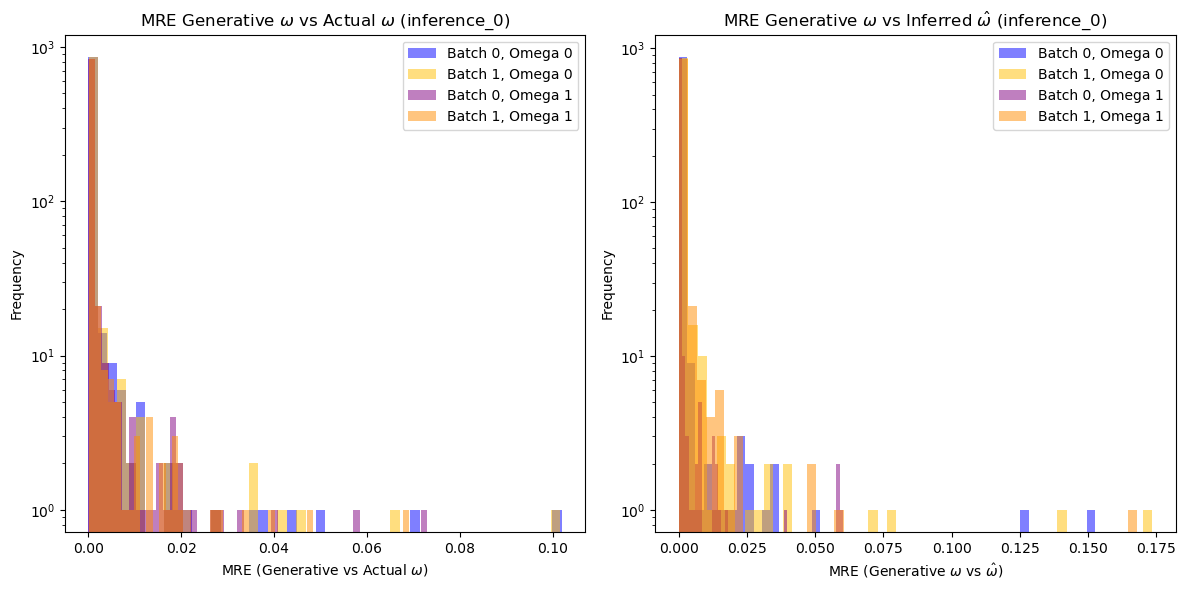

Worst True Omega [0,0]
gene                  gene_519
omega_0               0.170547
mu_0             170546.501775
omega_1                    0.0
mu_1                  0.995199
theta                        1
batch_applied                1
Name: gene_519, dtype: object
0.10193402507535357 0.17054681911870018
0.15013789314961581 0.12132128685885642

Worst True Omega [0,1]
gene                  gene_885
omega_0                0.10598
mu_0             105980.298074
omega_1               0.117874
mu_1             117874.857382
theta                        1
batch_applied                1
Name: gene_885, dtype: object
0.07301452898191121 0.11787440722463732
0.10916621402051409 0.08532597999749521

Worst Inferred Omega [0,0]
gene             gene_335
omega_0               0.0
mu_0             2.273137
omega_1               0.0
mu_1             0.757601
theta                   1
batch_applied           1
Name: gene_335, dtype: object
0.15268348669037624 1.2286390750338984e-07
0.15268360955428

In [12]:
# 1: Split the omegas by batch and omega_type
# 2. Pull the true omega from var table
# 3. Take batch corrected 0 and see how close batch 1 is to true omega relative to true batch 0
# concern about MRE - some of these are very far off... maybe plot the MRE as a histogram?
for inf_type in infy.inference_dict:
        print("Inference Type: ", inf_type)

        category_omegas_list, category_true_omegas_list = [], []

        inf_reinstate = infy.inference_dict[inf_type]
        adata = inf_reinstate.return_counts_as_anndata()
                
        # continuing on, lets pull Mu/Theta for this gene
        hat_mu = adata[0].X
        hat_theta = adata[0].layers["X_hat_theta"]
        true_counts = adata[0].layers["original_counts"]
                
        # lets convert true counts to omega
        library_size = np.sum(true_counts, axis=1)

        # Calculate omega (proportion of library size for each gene)
        true_omega = true_counts / library_size[:, np.newaxis]
                        
        omega = adata[0].layers["px_omega"]

        batches = adata[0].obs['batch']
        omega_types = adata[0].obs['omega_type']

        true_omega_0 = adata[0].var['omega_0']
        true_omega_1 = adata[0].var['omega_1']

        gene_order = inf_reinstate.ds.gene_names

        batches = adata[0].obs['batch'].astype('category')
        categories = batches.cat.categories

        # Prepare the DataFrame for omega
        df_omega = pd.DataFrame(omega, columns=[f'gene_{i}' for i in range(omega.shape[1])])
        df_omega['Batch'] = batches.to_numpy()
        df_omega['Omega'] = omega_types.to_numpy()

        # Prepare the DataFrame for true_omega
        df_true_omega = pd.DataFrame(true_omega, columns=[f'gene_{i}' for i in range(true_omega.shape[1])])
        df_true_omega['Batch'] = batches.to_numpy()
        df_true_omega['Omega'] = omega_types.to_numpy()

        # Group by 'Batch' and 'Omega' without computing the mean
        grouped_omega = df_omega.groupby(['Batch', 'Omega'])
        grouped_true_omega = df_true_omega.groupby(['Batch', 'Omega'])

        # Get the unique combinations of 'Batch' and 'Omega'
        batch_values = df_omega['Batch'].unique()
        omega_values = df_omega['Omega'].unique()

        # Initialize dictionaries to store results
        mre_results_omega = {}
        mre_results_true_omega = {}

        # Loop over each combination of 'Batch' and 'Omega'
        for batch in batch_values:
            for omega_type in omega_values:
                try:
                    # Get the group for the current batch and omega
                    group_omega = grouped_omega.get_group((batch, omega_type)).T
                    # Remove 'Batch' and 'Omega' rows
                    group_omega = group_omega.drop(['Batch', 'Omega'], errors='ignore')


                    # Get the corresponding true omega group
                    group_true_omega = grouped_true_omega.get_group((batch, omega_type)).T
                    group_true_omega = group_true_omega.drop(['Batch', 'Omega'], errors='ignore')
                    
                    # Calculate MRE/MSLE/sMAPE for each gene

                    if (omega_type == 1):
                        omega_to_compare = true_omega_1.copy()
                    else: 
                        omega_to_compare = true_omega_0.copy()

                    mre_omega = group_omega.apply(
                        # lambda row: calculate_mre(row, omega_to_compare[row.name]), axis=1
                        # lambda row: calculate_msle(row, omega_to_compare[row.name]), axis=1
                        # lambda row: calculate_smape(row, omega_to_compare[row.name]), axis=1
                        lambda row: calculate_mae(row, omega_to_compare[row.name]), axis=1
                    )
                    mre_true_omega = group_true_omega.apply(
                        # lambda row: calculate_mre(row, omega_to_compare[row.name]), axis=1
                        # lambda row: calculate_msle(row, omega_to_compare[row.name]), axis=1
                        # lambda row: calculate_smape(row, omega_to_compare[row.name]), axis=1
                        lambda row: calculate_mae(row, omega_to_compare[row.name]), axis=1
                    )
                    
                    print("batch", batch, "omega", omega_type)
                    print("omega", np.mean(omega_to_compare['gene_209']), true_omega_0['gene_209'])
                    print("Generated 227", np.mean(group_true_omega.loc['gene_209']))
                    print("Inferred 227", np.mean(group_omega.loc['gene_209']))
                    print(adata[0].var.loc['gene_209'])

                    # Store the results
                    mre_results_omega[(batch, omega_type)] = mre_omega
                    mre_results_true_omega[(batch, omega_type)] = mre_true_omega
                except KeyError:
                    print(f"No data for Batch {batch} and Omega {omega_type}")
            
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))


        # Plot histograms for the first gene
        num_bins = 50
        
        axes[0].hist((mre_results_true_omega[(0,0)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 0', color='blue')
        axes[0].hist((mre_results_true_omega[(1,0)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 0', color='#FFBF00')
        if (len(omega_values) > 1):
            axes[0].hist((mre_results_true_omega[(0,1)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 1', color='purple')
            axes[0].hist((mre_results_true_omega[(1,1)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 1', color='#FF8C00')
        axes[0].set_xlabel(r'MRE (Generative vs Actual $\omega$)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_yscale('log')

        axes[0].set_title(f'MRE Generative $\omega$ vs Actual $\omega$ ({inf_type})')
        axes[0].legend()

        # Plot histograms for the second gene
        axes[1].hist((mre_results_omega[(0,0)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 0', color='blue')
        axes[1].hist((mre_results_omega[(1,0)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 0', color='#FFBF00')
        if (len(omega_values) > 1):
            axes[1].hist((mre_results_omega[(0,1)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 1', color='purple')
            axes[1].hist((mre_results_omega[(1,1)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 1', color='#FF8C00')
        axes[1].set_xlabel(r'MRE (Generative $\omega$ vs $\hat{\omega}$)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_yscale('log')

        axes[1].set_title(f'MRE Generative $\omega$ vs Inferred $\hat{{\omega}}$ ({inf_type})')
        axes[1].legend()

        # Adjust layout and display the plots
        plt.tight_layout()
        plt.show()

       # print("0 0", np.min(mre_results_true_omega[(0,0)]), np.max(mre_results_true_omega[(0,0)]))
       # print("1 0", np.min(mre_results_true_omega[(1,0)]), np.max(mre_results_true_omega[(1,0)]))
       # if (len(omega_values) > 1):    
       #     print("0 1", np.min(mre_results_true_omega[(0,1)]), np.max(mre_results_true_omega[(0,1)]))
       #     print("1 1", np.min(mre_results_true_omega[(1,1)]), np.max(mre_results_true_omega[(1,1)]))


        # Get worst "true" MRE comparison
        print("Worst True Omega [0,0]")
        max_index = mre_results_true_omega[(0,0)].idxmax()
        print(adata[0].var.loc[max_index])
        print(mre_results_true_omega[(0,0)].max(), true_omega_0[max_index])
        group_true_omega = grouped_true_omega.get_group((0, 0)).T
        print(np.mean(group_true_omega.loc[max_index]), np.median(group_true_omega.loc[max_index]))

        #print()
        #print(calculate_msle(group_true_omega.loc[max_index], true_omega_0[max_index]))
        #print(true_omega_0[max_index])
        #print()
        #print(group_true_omega.loc[max_index])

        if (len(omega_values) > 1):
            print()
            print("Worst True Omega [0,1]")
            max_index = mre_results_true_omega[(0,1)].idxmax()
            print(adata[0].var.loc[max_index])
            print(mre_results_true_omega[(0,1)].max(), true_omega_1[max_index])
            group_true_omega = grouped_true_omega.get_group((0, 1)).T
            print(np.mean(group_true_omega.loc[max_index]), np.median(group_true_omega.loc[max_index]))

        print()
        print("Worst Inferred Omega [0,0]")
        max_index = mre_results_omega[(0,0)].idxmax()
        print(adata[0].var.loc[max_index])
        print(mre_results_omega[(0,0)].max(), true_omega_0[max_index])
        group_omega = grouped_omega.get_group((0, 0)).T
        print(np.mean(group_omega.loc[max_index]), np.median(group_omega.loc[max_index]))

        print()
        print("Worst Inferred Omega [1,0]")
        max_index = mre_results_omega[(1,0)].idxmax()
        print(adata[0].var.loc[max_index])
        print(mre_results_omega[(1,0)].max(), true_omega_0[max_index])
        group_omega = grouped_omega.get_group((1, 0)).T
        print(np.mean(group_omega.loc[max_index]), np.median(group_omega.loc[max_index]), np.min(group_omega.loc[max_index]), np.max(group_omega.loc[max_index]))

        if (len(omega_values) > 1):
            print()
            print("Worst Inferred Omega [0,1]")
            max_index = mre_results_omega[(0,1)].idxmax()
            print(adata[0].var.loc[max_index])
            print(mre_results_omega[(0,1)].max(), true_omega_1[max_index])
            group_omega = grouped_omega.get_group((0, 1)).T
            print(np.mean(group_omega.loc[max_index]), np.median(group_omega.loc[max_index]))

            print()
            print("Worst Inferred Omega [1,1]")
            max_index = mre_results_omega[(1,1)].idxmax()
            print(adata[0].var.loc[max_index])
            print(mre_results_omega[(1,1)].max(), true_omega_1[max_index])
            group_omega = grouped_omega.get_group((1, 1)).T
            print(np.mean(group_omega.loc[max_index]), np.median(group_omega.loc[max_index]))



In [13]:
# To confirm these results, lets dig deep into a particular example
# In batch 0, omega 0, gene 159 has a generative omega of 3.6e-06 but it's being inferred at 0.01

# 1. Recompute this line-by-line to confirm this observation.

inf_reinstate = infy.inference_dict['endogenous']
adata = inf_reinstate.return_counts_as_anndata()
                

hat_mu = adata[0].X
hat_theta = adata[0].layers["X_hat_theta"]
true_counts = adata[0].layers["original_counts"]

omega = adata[0].layers["px_omega"]


gene_of_interest = pd.DataFrame(np.transpose(omega)).iloc[159]

gene_of_interest.index = adata[0].obs['batch'].index


goi_batch_0_omega_0 = gene_of_interest[(~adata[0].obs['batch'].astype(bool)) & (~adata[0].obs['omega_type'].astype(bool))]

print(np.min(goi_batch_0_omega_0), np.mean(goi_batch_0_omega_0), np.max(goi_batch_0_omega_0))


batches = adata[0].obs['batch']
omega_types = adata[0].obs['omega_type']

true_omega_0 = adata[0].var['omega_0']
true_omega_1 = adata[0].var['omega_1']

gene_order = inf_reinstate.ds.gene_names

batches = adata[0].obs['batch'].astype('category')
categories = batches.cat.categories

# Prepare the DataFrame for omega
df_omega = pd.DataFrame(omega, columns=[f'gene_{i}' for i in range(omega.shape[1])])
df_omega['Batch'] = batches.to_numpy()
df_omega['Omega'] = omega_types.to_numpy()
category_means_omega = df_omega.groupby(['Batch', 'Omega']).mean().T

print(category_means_omega.loc['gene_159'])

# so we can see that Batch 0 and Omega 0 is way off, while Batch 1 Omega 0 is on the money



3.0866362067172304e-05 6.526971264975145e-05 9.15526834432967e-05
Batch  Omega
0      0        0.000065
       1        0.000010
1      0        0.000309
       1        0.000227
Name: gene_159, dtype: float32


In [14]:
# Next: Lets isolate genes with a batch effect; then compute the MRE for batch 1 in endogenous and "inference_0" to see if we measure a marked improvement by the batch correction

for inf_type in infy.inference_dict:


        if (inf_type == "inference_1"):
             break
        print("Inference Type: ", inf_type)
    

        inf_reinstate = infy.inference_dict[inf_type]
        adata = inf_reinstate.return_counts_as_anndata()
                
        # continuing on, lets pull Mu/Theta for this gene
        hat_mu = adata[0].X
        hat_theta = adata[0].layers["X_hat_theta"]
        true_counts = adata[0].layers["original_counts"]
                
        # lets convert true counts to omega
        library_size = np.sum(true_counts, axis=1)

        # Calculate omega (proportion of library size for each gene)
        true_omega = true_counts / library_size[:, np.newaxis]
                        
        omega = adata[0].layers["px_omega"]

        batches = adata[0].obs['batch']
        omega_types = adata[0].obs['omega_type']

        true_omega_0 = adata[0].var['omega_0']
        true_omega_1 = adata[0].var['omega_1']

        gene_order = inf_reinstate.ds.gene_names

        batches = adata[0].obs['batch'].astype('category')
        categories = batches.cat.categories

        # Prepare the DataFrame for omega
        df_omega = pd.DataFrame(omega, columns=[f'gene_{i}' for i in range(omega.shape[1])])
        df_omega['Batch'] = batches.to_numpy()
        df_omega['Omega'] = omega_types.to_numpy()

        # Prepare the DataFrame for true_omega
        df_true_omega = pd.DataFrame(true_omega, columns=[f'gene_{i}' for i in range(true_omega.shape[1])])
        df_true_omega['Batch'] = batches.to_numpy()
        df_true_omega['Omega'] = omega_types.to_numpy()

        # Group by 'Batch' and 'Omega' without computing the mean
        grouped_omega = df_omega.groupby(['Batch', 'Omega'])
        grouped_true_omega = df_true_omega.groupby(['Batch', 'Omega'])

        # Get the unique combinations of 'Batch' and 'Omega'
        batch_values = df_omega['Batch'].unique()
        omega_values = df_omega['Omega'].unique()

        # Initialize dictionaries to store results
        mre_results_omega = {}
        mre_results_true_omega = {}

        # Loop over each combination of 'Batch' and 'Omega'
        for batch in batch_values:
            for omega_type in omega_values:
                try:
                    # Get the group for the current batch and omega
                    group_omega = grouped_omega.get_group((batch, omega_type)).T
                    # Remove 'Batch' and 'Omega' rows
                    group_omega = group_omega.drop(['Batch', 'Omega'], errors='ignore')


                    # Get the corresponding true omega group
                    group_true_omega = grouped_true_omega.get_group((batch, omega_type)).T
                    group_true_omega = group_true_omega.drop(['Batch', 'Omega'], errors='ignore')
                    
                    # Calculate MRE for each gene

                    if (omega_type == 1):
                        omega_to_compare = true_omega_1.copy()
                    else: 
                        omega_to_compare = true_omega_0.copy()

                    mre_omega = group_omega.apply(
                        # lambda row: calculate_mre(row, omega_to_compare[row.name]), axis=1
                        lambda row: calculate_mae(row, omega_to_compare[row.name]), axis=1
                        # lambda row: calculate_msle(row, omega_to_compare[row.name]), axis=1
                        # lambda row: calculate_smape(row, omega_to_compare[row.name]), axis=1
                    )
                    mre_true_omega = group_true_omega.apply(
                        # lambda row: calculate_mre(row, omega_to_compare[row.name]), axis=1
                        lambda row: calculate_mae(row, omega_to_compare[row.name]), axis=1
                        # lambda row: calculate_msle(row, omega_to_compare[row.name]), axis=1
                        # lambda row: calculate_smape(row, omega_to_compare[row.name]), axis=1
                    )
                

                    # Store the results
                    mre_results_omega[(batch, omega_type)] = mre_omega
                    mre_results_true_omega[(batch, omega_type)] = mre_true_omega
                except KeyError:
                    print(f"No data for Batch {batch} and Omega {omega_type}")
            
        # Now we want to isolate just the genes that received a batch effect

        if (dataset_run == "dataset_omega_batch_1"): 
             batch_applied = np.ones(len(adata[0].var))
        else:   

            batch_applied = adata[0].var['batch_applied']

        mre_batch_1_omega_0 = mre_results_omega[(1,0)]
        mre_batch_1_omega_0_batch_applied = mre_batch_1_omega_0[(batch_applied.astype(bool))]
        print("Omega_0: ", np.mean(mre_batch_1_omega_0_batch_applied), np.std(mre_batch_1_omega_0_batch_applied), "Max", np.max(mre_batch_1_omega_0_batch_applied))

        mre_batch_1_omega_0_batch_applied_filtered = mre_batch_1_omega_0_batch_applied[mre_batch_1_omega_0_batch_applied <= 0.8]
        print("Omega_0_Filtered: ", np.mean(mre_batch_1_omega_0_batch_applied_filtered), np.std(mre_batch_1_omega_0_batch_applied_filtered), "Max", np.max(mre_batch_1_omega_0_batch_applied_filtered))


        if (len(omega_values)) > 1:
            mre_batch_1_omega_1 = mre_results_omega[(1,1)]

            # only MREs where batch waas applied in batch 1 samples
            mre_batch_1_omega_1_batch_applied = mre_batch_1_omega_1[(batch_applied.astype(bool))]
            print("Omega_1: ", np.mean(mre_batch_1_omega_1_batch_applied), np.std(mre_batch_1_omega_1_batch_applied), "Max", np.max(mre_batch_1_omega_1_batch_applied))
            print()
            # lets get rid of the top issue because of outliers
            mre_batch_1_omega_1_batch_applied_filtered = mre_batch_1_omega_1_batch_applied[mre_batch_1_omega_1_batch_applied <= 166]
            print("Omega_1_Filtered: ", np.mean(mre_batch_1_omega_1_batch_applied_filtered), np.std(mre_batch_1_omega_1_batch_applied_filtered), "Max", np.max(mre_batch_1_omega_1_batch_applied_filtered))



Inference Type:  endogenous
Omega_0:  0.001221070590962859 0.0070212623111213365 Max 0.15766639957818812
Omega_0_Filtered:  0.001221070590962859 0.0070212623111213365 Max 0.15766639957818812
Omega_1:  0.0011155451326163232 0.00517672543522197 Max 0.10454848368252401

Omega_1_Filtered:  0.0011155451326163232 0.00517672543522197 Max 0.10454848368252401
Inference Type:  inference_0
Omega_0:  0.0011630682968109887 0.008755201160608829 Max 0.17342959634932442
Omega_0_Filtered:  0.0011630682968109887 0.008755201160608829 Max 0.17342959634932442
Omega_1:  0.0009414467821587275 0.006706405636923398 Max 0.16783818560510727

Omega_1_Filtered:  0.0009414467821587275 0.006706405636923398 Max 0.16783818560510727


In [15]:
# Jensen Shannon Divergence
from scipy.spatial import distance

def compute_jsd_scipy(P, Q):
    # Ensure that P and Q are numpy arrays
    P = np.array(P)
    Q = np.array(Q)

    # Normalize the distributions so they sum to 1
    P = P / np.sum(P)
    Q = Q / np.sum(Q)

    # Compute Jensen-Shannon distance
    js_distance = distance.jensenshannon(P, Q)
    
    # Square the Jensen-Shannon distance to get the divergence
    js_divergence = js_distance ** 2
    return js_divergence

# checking to see if not using SciPy is a big deal or not (turns out they're equivalent)
def compute_jsd(P, Q):
    # Convert to numpy arrays
    P = np.array(P, dtype=np.float64)
    Q = np.array(Q, dtype=np.float64)

    # Normalize the distributions
    P /= np.sum(P)
    Q /= np.sum(Q)

    

    # Calculate the average distribution
    M = 0.5 * (P + Q)

    # Replace zeros to avoid log(0)
    epsilon = 1e-10
    P = np.where(P == 0, epsilon, P)
    Q = np.where(Q == 0, epsilon, Q)
    M = np.where(M == 0, epsilon, M)

    # Compute Kullback-Leibler divergences
    KL_P_M = np.sum(P * np.log(P / M))
    KL_Q_M = np.sum(Q * np.log(Q / M))

    # Compute Jensen-Shannon Divergence
    JSD = 0.5 * (KL_P_M + KL_Q_M)
    return JSD



Inference Type:  endogenous


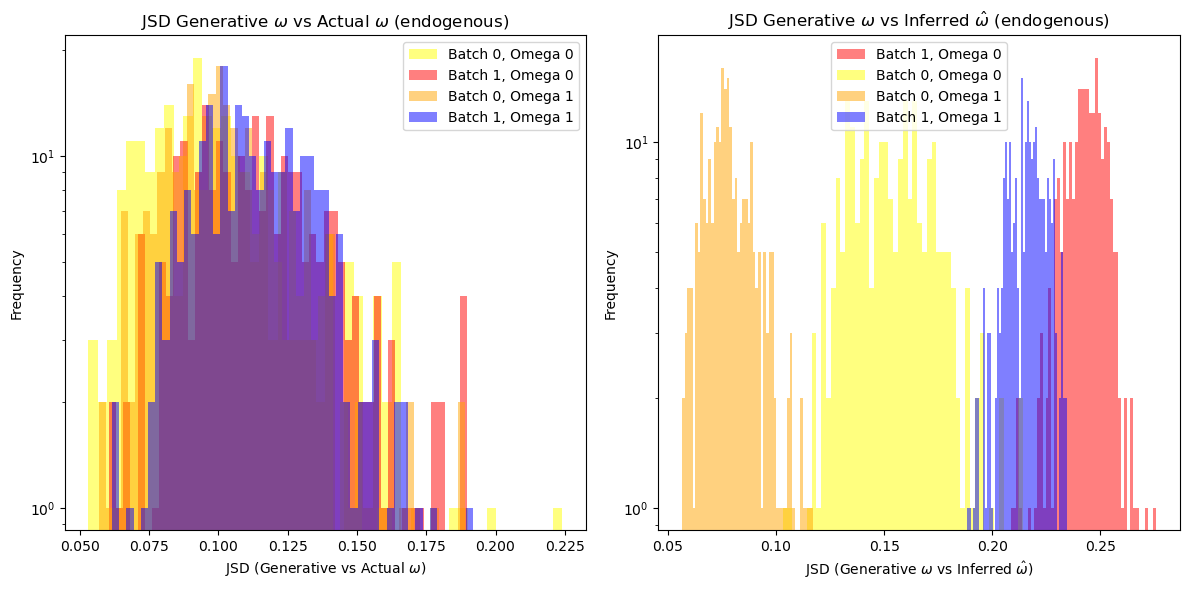

Index      JSD  
Batch 0, Omega 0, Generative:0.00085
Batch 0, Omega 0, Inference:0.15278
Batch 0, Omega 1, Generative:0.00062
Batch 0, Omega 1, Inference:0.07886
Batch 1, Omega 0, Generative:0.02161
Batch 1, Omega 0, Inference:0.2425
Batch 1, Omega 1, Generative:0.02118
Batch 1, Omega 1, Inference:0.21538

Inference Type:  inference_0


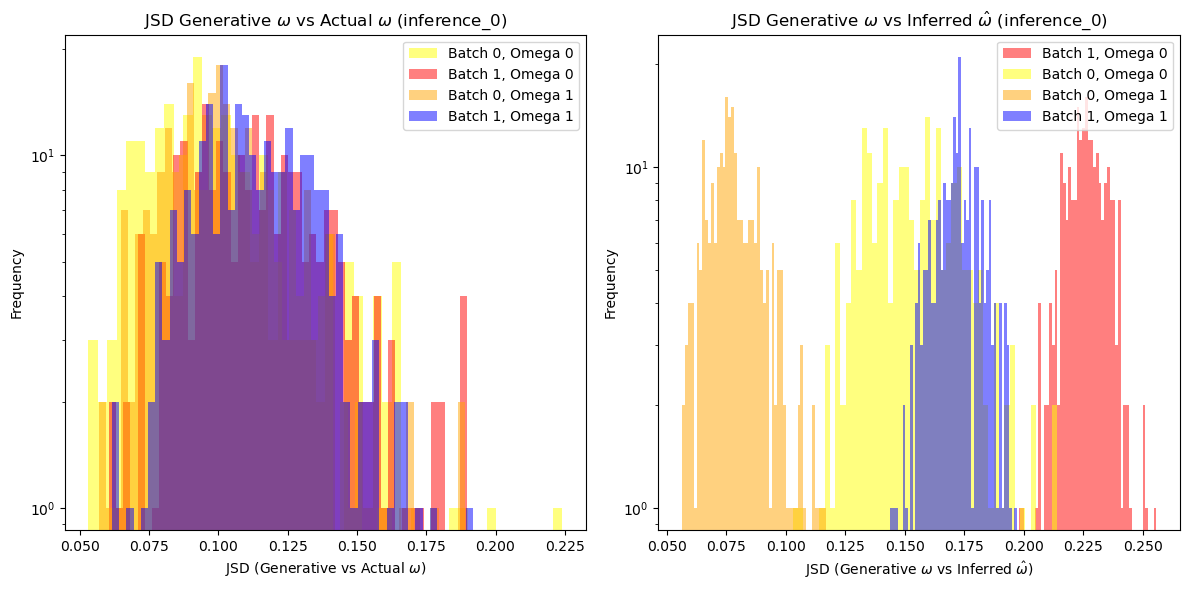

Index      JSD  
Batch 0, Omega 0, Generative:0.00085
Batch 0, Omega 0, Inference:0.15278
Batch 0, Omega 1, Generative:0.00062
Batch 0, Omega 1, Inference:0.07886
Batch 1, Omega 0, Generative:0.02161
Batch 1, Omega 0, Inference:0.22617
Batch 1, Omega 1, Generative:0.02118
Batch 1, Omega 1, Inference:0.17214



In [16]:
batch_cor = {}

for inf_type in infy.inference_dict:

        if (inf_type == "inference_1"):
             break
        print("Inference Type: ", inf_type)
    

        inf_reinstate = infy.inference_dict[inf_type]
        adata = inf_reinstate.return_counts_as_anndata()
                
        # continuing on, lets pull Mu/Theta for this gene
        hat_mu = adata[0].X
        hat_theta = adata[0].layers["X_hat_theta"]
        true_counts = adata[0].layers["original_counts"]
                
        # lets convert true counts to omega
        library_size = np.sum(true_counts, axis=1)

        # Calculate omega (proportion of library size for each gene)
        true_omega = true_counts / library_size[:, np.newaxis]
                        
        omega = adata[0].layers["px_omega"]

        batches = adata[0].obs['batch']
        omega_types = adata[0].obs['omega_type']

        true_omega_0 = adata[0].var['omega_0']
        true_omega_1 = adata[0].var['omega_1']

        gene_order = inf_reinstate.ds.gene_names

        batches = adata[0].obs['batch'].astype('category')
        categories = batches.cat.categories

        # Prepare the DataFrame for omega
        df_omega = pd.DataFrame(omega, columns=[f'gene_{i}' for i in range(omega.shape[1])])
        df_omega['Batch'] = batches.to_numpy()
        df_omega['Omega'] = omega_types.to_numpy()

        # Prepare the DataFrame for true_omega
        df_true_omega = pd.DataFrame(true_omega, columns=[f'gene_{i}' for i in range(true_omega.shape[1])])
        df_true_omega['Batch'] = batches.to_numpy()
        df_true_omega['Omega'] = omega_types.to_numpy()

        # Group by 'Batch' and 'Omega' without computing the mean
        grouped_omega = df_omega.groupby(['Batch', 'Omega'])
        grouped_true_omega = df_true_omega.groupby(['Batch', 'Omega'])

        # Get the unique combinations of 'Batch' and 'Omega'
        batch_values = df_omega['Batch'].unique()
        omega_values = df_omega['Omega'].unique()

        jsd_results_omega = {}
        jsd_results_true_omega = {}

        jsd_results_average = {}

        # now we want to compare the distribution of omegas by batch
        for batch in batch_values:
            for omega_type in omega_values:
                
                    # Get the group for the current batch and omega
                    group_omega = grouped_omega.get_group((batch, omega_type)).T
                    # Remove 'Batch' and 'Omega' rows
                    group_omega = group_omega.drop(['Batch', 'Omega'], errors='ignore')


                    # Get the corresponding true omega group
                    group_true_omega = grouped_true_omega.get_group((batch, omega_type)).T
                    group_true_omega = group_true_omega.drop(['Batch', 'Omega'], errors='ignore')

                    # check to make sure the sum of average omegas (it's good)
                    # print(group_omega.mean(axis=1).sum())
                    # print(group_true_omega.mean(axis=1).sum())

                    group_omega_mean_disribution = group_omega.mean(axis=1)
                    group_true_omega_mean_disribution = group_true_omega.mean(axis=1)

                    if (omega_type == 1):
                        omega_to_compare = true_omega_1.copy()
                    else: 
                        omega_to_compare = true_omega_0.copy()

                    
                    true_jsd_scipy = compute_jsd_scipy(group_true_omega_mean_disribution, omega_to_compare)
                    inferred_jsd_scipy = compute_jsd_scipy(group_omega_mean_disribution, omega_to_compare)

                    #print("Max omega:", np.max(group_omega_mean_disribution), np.sum(group_omega_mean_disribution))

                    # they come out to be about the same
                    #true_jsd = compute_jsd(group_true_omega_mean_disribution, omega_to_compare)
                    #inferred_jsd = compute_jsd(group_omega_mean_disribution, omega_to_compare)

                    #print ("BATCH", batch, "OMEGA", omega_type)
                    #print("JSD True", round(true_jsd_scipy,5))
                    #print("JSD Inferred", round(inferred_jsd_scipy, 5))
                    #num_bins = 50
                    #fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                    #axes[0].hist((group_true_omega_mean_disribution), bins=num_bins, alpha=0.5, label='True Omega', color='red')
                    #axes[0].hist((omega_to_compare), bins=num_bins, alpha=0.5, label='Generative Omega', color='blue')
                    #axes[0].set_xlabel(r'Generative vs Actual $\omega$')
                    #axes[0].set_ylabel('Frequency')
                    #axes[0].set_yscale('log')

                    #axes[0].set_title(f'Generative $\omega$ vs Actual $\omega$ ({inf_type})')
                    #axes[0].legend()

                    # Plot histograms for the second gene

                    #axes[1].hist((group_omega_mean_disribution), bins=num_bins, alpha=0.5, label='Inferred Omega', color='red')
                    #axes[1].hist((omega_to_compare), bins=num_bins, alpha=0.5, label='Generative Omega', color='blue')

                    #axes[1].set_xlabel(r'Generative $\omega$ vs Inferred $\hat{\omega}$')
                    #axes[1].set_ylabel('Frequency')
                    #axes[1].set_yscale('log')

                    #axes[1].set_title(f'Generative $\omega$ vs Inferred $\hat{{\omega}}$ ({inf_type})')
                    #axes[1].legend()

                    # Adjust layout and display the plots
                    #plt.tight_layout()
                    #plt.show()

                    # are the genes with high omegas the same between inferred and generative?
                    thresh = 0.008
                    genes_above_threshold = group_omega_mean_disribution[group_omega_mean_disribution > thresh].index

                    #print(f"Inferred Omegas > {thresh}:")
                    #for gene in genes_above_threshold:
                    #    print(gene)

                    genes_above_threshold = omega_to_compare[omega_to_compare > thresh].index

                    #print(f"Generative Omegas > {thresh}:")
                    #for gene in genes_above_threshold:
                    #    print(gene)

                    #print()


                    jsd_omega = group_omega.apply(
                        lambda col: compute_jsd_scipy(col, omega_to_compare), axis=0
                    )
                    jsd_true_omega = group_true_omega.apply(
                       lambda col: compute_jsd_scipy(col, omega_to_compare), axis=0
                    )

                    jsd_results_omega[(batch, omega_type)] = jsd_omega
                    jsd_results_true_omega[(batch, omega_type)] = jsd_true_omega

                    jsd_results_average[(batch, omega_type, 0)] = round(true_jsd_scipy,5)
                    jsd_results_average[(batch, omega_type, 1)] = round(inferred_jsd_scipy, 5)

        num_bins = 50
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].hist((jsd_results_true_omega[(0,0)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 0', color='yellow')
        axes[0].hist((jsd_results_true_omega[(1,0)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 0', color='red')

        if (len(omega_values) > 1):
            axes[0].hist((jsd_results_true_omega[(0,1)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 1', color='orange')
            axes[0].hist((jsd_results_true_omega[(1,1)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 1', color='blue')
        axes[0].set_xlabel(r'JSD (Generative vs Actual $\omega$)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_yscale('log')

        axes[0].set_title(f'JSD Generative $\omega$ vs Actual $\omega$ ({inf_type})')
        axes[0].legend()

        # Plot histograms for the second gene

        axes[1].hist((jsd_results_omega[(1,0)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 0', color='red')
        axes[1].hist((jsd_results_omega[(0,0)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 0', color='yellow')

        if (len(omega_values) > 1):
            axes[1].hist((jsd_results_omega[(0,1)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 1', color='orange')
            axes[1].hist((jsd_results_omega[(1,1)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 1', color='blue')
        axes[1].set_xlabel(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_yscale('log')

        axes[1].set_title(f'JSD Generative $\omega$ vs Inferred $\hat{{\omega}}$ ({inf_type})')
        axes[1].legend()

        # Adjust layout and display the plots
        plt.tight_layout()

        plot_name = 'JSD_Generated_and_Inferred_Both_Batches.' + inf_type + ".pdf"
        plt.savefig(image_save + '/' + plot_name)


        plt.show()

        batch_cor[inf_type] = jsd_results_omega

        # and the final table
        print(f"{'Index':<10} {'JSD':<5}")

        # Iterate over the dictionary and print each key-value pair
        for key, value in jsd_results_average.items():
            if (key == (1,0,0)):
                key = "Batch 1, Omega 0, Generative"
            elif (key == (1,0,1)):
                key = "Batch 1, Omega 0, Inference"
            elif (key == (0,0,0)):
                key = "Batch 0, Omega 0, Generative"
            elif (key == (0,0,1)):
                key = "Batch 0, Omega 0, Inference"
            elif (key == (1,1,0)):
                key = "Batch 1, Omega 1, Generative"
            elif (key == (1,1,1)):
                key = "Batch 1, Omega 1, Inference"
            elif (key == (0,1,0)):
                key = "Batch 0, Omega 1, Generative"
            elif (key == (0,1,1)):
                key = "Batch 0, Omega 1, Inference"



            print(f"{key}:{value:<5}")
        print()
        
                    

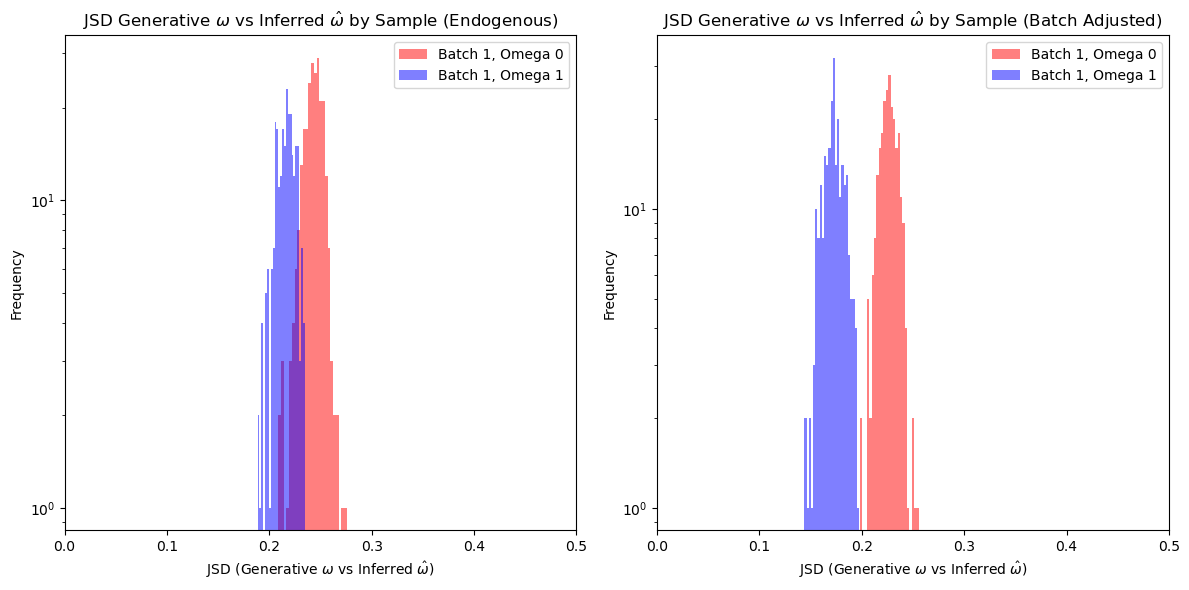

In [17]:
# and lets post just the JSD of \hat{omega} before and after batch adjustment


num_bins = 25
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist((batch_cor['endogenous'][(1,0)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 0', color='red')

if (len(omega_values) > 1):
    axes[0].hist((batch_cor['endogenous'][(1,1)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 1', color='blue')
axes[0].set_xlabel(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$)')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].set_xlim(0, 0.5)

axes[0].set_title(f'JSD Generative $\omega$ vs Inferred $\hat{{\omega}}$ by Sample (Endogenous)')
axes[0].legend()

# Plot histograms for the second gene

axes[1].hist(batch_cor['inference_0'][(1,0)], bins=num_bins, alpha=0.5, label='Batch 1, Omega 0', color='red')
if (len(omega_values) > 1):
    axes[1].hist(batch_cor['inference_0'][(1,1)], bins=num_bins, alpha=0.5, label='Batch 1, Omega 1', color='blue')
axes[1].set_xlabel(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$)')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')
axes[1].set_xlim(0, 0.5)
axes[1].set_title(f'JSD Generative $\omega$ vs Inferred $\hat{{\omega}}$ by Sample (Batch Adjusted)')
axes[1].legend()
plt.tight_layout()

plot_name = 'JSD_inferred_batch_1.endogenous_to_adjusted.pdf'
plt.savefig(image_save + '/' + plot_name)

plt.show()

In [18]:
print(contingency_table)

omega_type    0    1
batch               
0           237  259
1           251  253


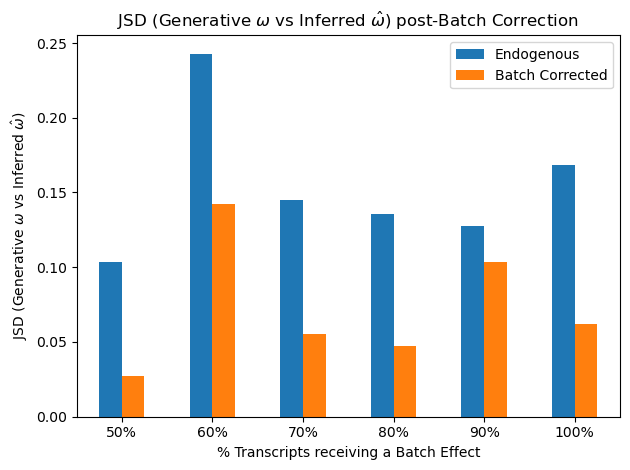

In [ ]:
# Now lets plot the results which I've been compiling in an Excel document (JSD_Omega_Batch_Evaluation.xslx)
jsd_results_test2 = {
    'Endogenous': [0.10379,
0.24293,
0.14473,
0.13594,
0.12749,
0.16857],
    'Batch Corrected': [0.0275,
0.14223,
0.05538,
0.04707,
0.10357,
0.06171]
}




# Define row names
row_names = ['50%', '60%', '70%', '80%', '90%', '100%']

# Create the DataFrame
df = pd.DataFrame(jsd_results_test2, index=row_names)

df.plot(kind='bar')

# Set x-tick labels to row names
plt.xlabel('% Transcripts with a Batch Effect')
plt.ylabel(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$)')
plt.title(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$) post-Batch Correction')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

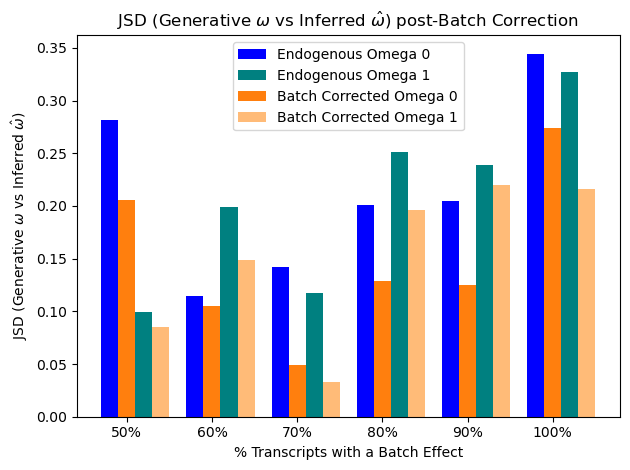

In [ ]:
# Now lets plot the results which I've been compiling in an Excel document (JSD_Omega_Batch_Evaluation.xslx)
# Test #3, with models derived using 1000 epochs (will re-run with EP2000)
jsd_results_test3 = {
    'Endogenous Omega 0': [0.28123,
0.11469,
0.14216,
0.20048,
0.20481,
0.34452],

    'Batch Corrected Omega 0': [0.20603,
0.10517,
0.04949,
0.12907,
0.12527,
0.27359],
        'Endogenous Omega 1': [0.09954,
0.19912,
0.11694,
0.25123,
0.23913,
0.32713],
    'Batch Corrected Omega 1': [0.08497,
0.14863,
0.03329,
0.19576,
0.21975,
0.2161],
}




# Define row names
row_names = ['50%', '60%', '70%', '80%', '90%', '100%']

# Create the DataFrame
df = pd.DataFrame(jsd_results_test3, index=row_names)



# Number of categories
n_rows = len(df)
# Number of columns (groups of bars)
n_columns = len(df.columns)

# Positions of bars on x-axis
bar_width = 0.2  # Width of each bar
x = np.arange(n_rows)

# Create figure and axis
fig, ax = plt.subplots()

# Plot bars with custom positions to add separation
ax.bar(x - bar_width, df['Endogenous Omega 0'], width=bar_width, label='Endogenous Omega 0', color="blue")
ax.bar(x + bar_width, df['Endogenous Omega 1'], width=bar_width, label='Endogenous Omega 1', color="teal")
ax.bar(x, df['Batch Corrected Omega 0'], width=bar_width, label='Batch Corrected Omega 0', color="#ff7f0e")
ax.bar(x + bar_width*2, df['Batch Corrected Omega 1'], width=bar_width, label='Batch Corrected Omega 1', color="#ffbb78")

# Set x-ticks to row names
ax.set_xticks(x)
ax.set_xticklabels(df.index)

# Add labels and title
ax.set_xlabel('% Transcripts with a Batch Effect')
ax.set_ylabel(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$)')
ax.set_title(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$) post-Batch Correction')
ax.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


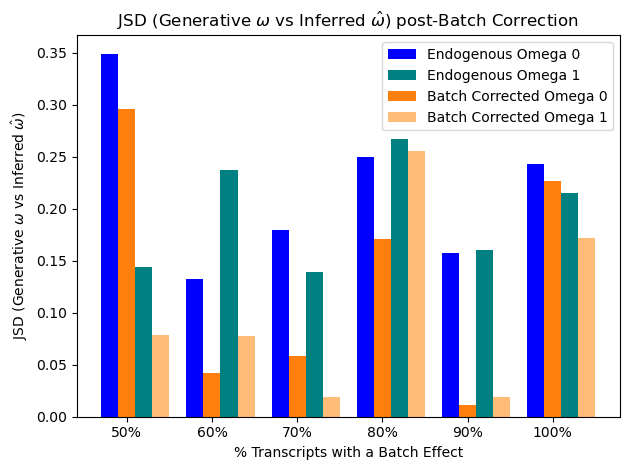

In [20]:
# These numbers are from a fixed re-run where r_prime was set to 128 (accidentally left it at 25 after the PAM50 work)
jsd_results_test3 = {
    'Endogenous Omega 0': [0.34899,
0.13263,
0.17936,
0.24916,
0.15708,
0.2425],

    'Batch Corrected Omega 0': [0.2955,
0.04248,
0.05851,
0.17032,
0.01161,
0.22617],
        'Endogenous Omega 1': [0.14364,
0.23666,
0.13923,
0.26723,
0.15991,
0.21538],
    'Batch Corrected Omega 1': [0.0785,
0.0773,
0.01926,
0.25584,
0.0186,
0.17214],
}




# Define row names
row_names = ['50%', '60%', '70%', '80%', '90%', '100%']

# Create the DataFrame
df = pd.DataFrame(jsd_results_test3, index=row_names)



# Number of categories
n_rows = len(df)
# Number of columns (groups of bars)
n_columns = len(df.columns)

# Positions of bars on x-axis
bar_width = 0.2  # Width of each bar
x = np.arange(n_rows)

# Create figure and axis
fig, ax = plt.subplots()

# Plot bars with custom positions to add separation
ax.bar(x - bar_width, df['Endogenous Omega 0'], width=bar_width, label='Endogenous Omega 0', color="blue")
ax.bar(x + bar_width, df['Endogenous Omega 1'], width=bar_width, label='Endogenous Omega 1', color="teal")
ax.bar(x, df['Batch Corrected Omega 0'], width=bar_width, label='Batch Corrected Omega 0', color="#ff7f0e")
ax.bar(x + bar_width*2, df['Batch Corrected Omega 1'], width=bar_width, label='Batch Corrected Omega 1', color="#ffbb78")

# Set x-ticks to row names
ax.set_xticks(x)
ax.set_xticklabels(df.index)

# Add labels and title
ax.set_xlabel('% Transcripts with a Batch Effect')
ax.set_ylabel(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$)')
ax.set_title(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$) post-Batch Correction')
ax.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
